In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math, os
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
import numpy as np
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\Quantomatic.jar'

In [37]:
#g = zx.generate.identity(1,2)
#g = zx.quantomatic.edit_graph(g)
circ_name = r'../circuits/fast/adder_8_before'
c_orig = zx.Circuit.load(circ_name).to_basic_gates()
print(c_orig.stats())
#display(zx.draw(c_orig,figsize=(10,3),h_edge_draw='box'))
g = c_orig.to_graph()
#g = zx.generate.cliffordT(4,100, p_t=0.2)
# zx.simplify.clifford_simp(g)
# zx.simplify.pivot_gadget_simp(g)
# zx.simplify.clifford_simp(g)
# zx.simplify.gadget_simp(g)
# zx.simplify.interior_clifford_simp(g)
# zx.simplify.pivot_gadget_simp(g)
# zx.simplify.gadget_simp(g)
# zx.simplify.interior_clifford_simp(g)
# zx.simplify.pivot_gadget_simp(g)
# zx.simplify.interior_clifford_simp(g)
zx.simplify.full_reduce(g,quiet=False)
g.normalise()
print(zx.tcount(g))
print("vertex count", len(list(g.vertices())))
#zx.draw(g,labels=True)

Circuit adder_8_before on 24 qubits with 1014 gates.
        399 is the T-count
        615 Cliffords among which 
        409 2-qubit gates and 194 Hadamard gates.
spider_simp: 171. 129. 76. 37. 23. 14. 8. 5. 3. 1.  10 iterations
id_simp: 108. 57.  2 iterations
spider_simp: 21. 2.  2 iterations
pivot_simp: 31. 4. 2. 1. 1.  5 iterations
lcomp_simp: 6. 6.  2 iterations
id_simp: 5.  1 iterations
spider_simp: 4.  1 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 3. 3.  2 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_gadget_simp: 141. 58. 35. 22. 12. 9. 5. 3. 2.  9 iterations
id_simp: 52.  1 iterations
spider_simp: 16. 12. 7. 4. 4. 1. 1. 1. 1.  9 iterations
pivot_simp: 3.  1 iterations
lcomp_simp: 6. 6. 2. 2. 1. 1.  6 iterations
id_simp: 4.  1 iterations
spider_simp: 2. 1. 1.  3 iterations
pivot_simp: 3.  1 iterations
id_simp: 2.  1 iterations
spider_simp: 2.  1 iterations
lcomp_simp: 2. 2.  2 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations

In [23]:
g.outputs

[1447,
 1448,
 1449,
 1450,
 1451,
 1452,
 1453,
 1454,
 1455,
 1456,
 1457,
 1458,
 1459,
 1460,
 1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1469,
 1470]

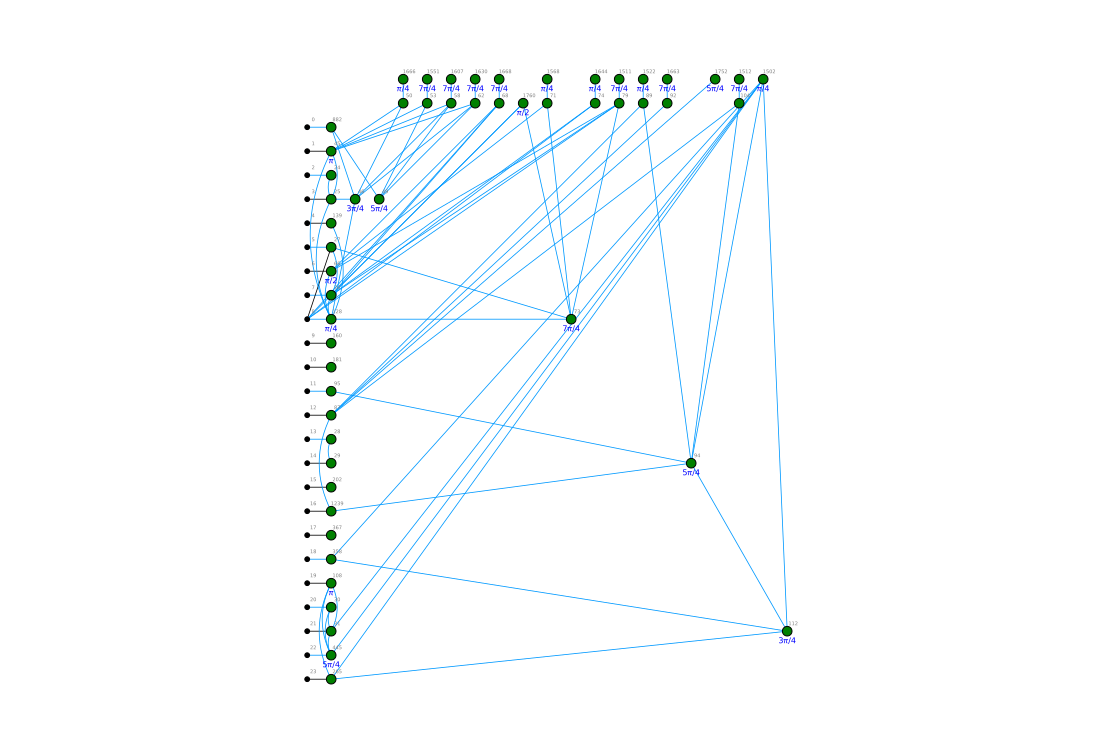

In [32]:
zx.draw(g,figsize=(15,10),rows=(0,20),labels=True)

In [16]:
g2 = zx.simplify.teleport_reduce(c_orig.to_graph())
print(zx.tcount(g2))

31


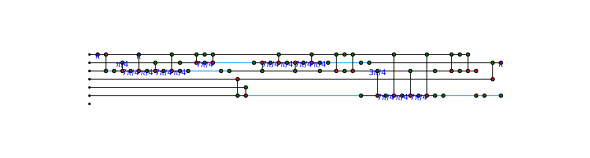

In [6]:
zx.draw(g2,rows=(0,50))

In [17]:
c = zx.Circuit.from_graph(g2)
print(c.stats())

Circuit  on 9 qubits with 110 gates.
        31 is the T-count
        79 Cliffords among which 
        42 2-qubit gates and 28 Hadamard gates.


In [18]:
zx.compare_tensors(c_orig,c)

True

In [19]:
c2 = zx.optimize.basic_optimization(c)
print(c2.stats())

Circuit  on 9 qubits with 90 gates.
        31 is the T-count
        59 Cliffords among which 
        36 2-qubit gates and 14 Hadamard gates.


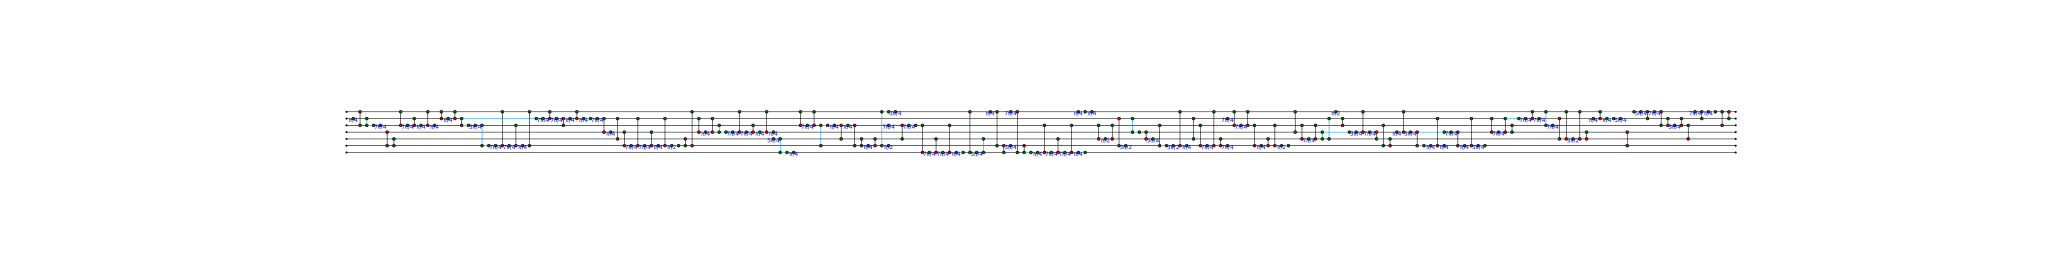

In [11]:
zx.draw(c2,figsize=(40,5))

In [38]:
d = zx.extract.streaming_extract(g)
print(d.stats())

Circuit  on 24 qubits with 2503 gates.
        173 is the T-count
        2330 Cliffords among which 
        913 2-qubit gates and 1362 Hadamard gates.
There are 120 gates of a different type


In [21]:
d2 = zx.optimize.basic_optimization(d.to_basic_gates())
print(d2.stats())

Circuit  on 9 qubits with 163 gates.
        31 is the T-count
        132 Cliffords among which 
        112 2-qubit gates and 18 Hadamard gates.


spider_simp: 51. 34. 22. 11. 5. 3. 1.  7 iterations
id_simp: 32. 15. 2.  3 iterations
spider_simp: 7. 1.  2 iterations
pivot_simp: 15. 4. 2. 1.  4 iterations
lcomp_simp: 3. 3.  2 iterations
id_simp: 2.  1 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1. 1.  2 iterations
pivot_gadget_simp: 37. 16. 9. 4. 1. 1.  6 iterations
id_simp: 7.  1 iterations
spider_simp: 3. 2. 1.  3 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 1. 1.  2 iterations
gadget_simp: 6.  1 iterations
lcomp_simp: 5. 5.  2 iterations
75
75


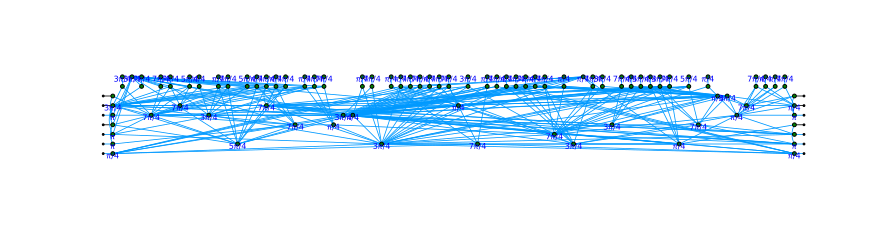

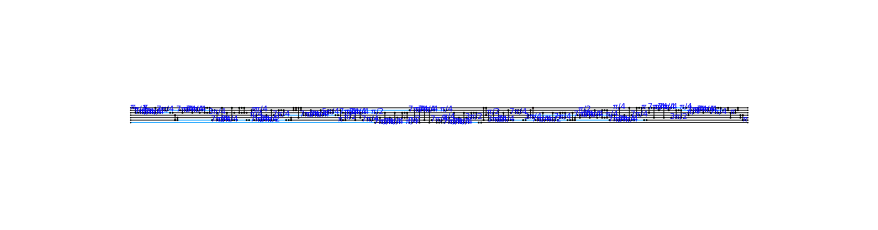

True


In [58]:
class Simplifier(object):
    def __init__(self, g):
        g.track_phases = True
        self.mastergraph = g.copy()
        self.simplifygraph = g.copy()
        self.simplifygraph.set_phase_master(self)

    def fuse_phases(self,i1, i2):
        try:
            v1 = self.mastergraph.vertex_from_phase_index(i1)
            v2 = self.mastergraph.vertex_from_phase_index(i2)
        except ValueError: pass
        p = self.mastergraph.phase(v2)
        self.mastergraph.add_to_phase(v1,p)
        self.mastergraph.set_phase(v2,0)
    
    def spider_fusion(self):
        zx.simplify.spider_simp(self.simplifygraph)
    
    def identity_removal(self):
        zx.simplify.id_simp(self.simplifygraph)
        self.spider_fusion()
    
    def clifford_simp(self):
        zx.simplify.interior_clifford_simp(self.simplifygraph)
    
    def gadgetize(self):
        zx.simplify.pivot_gadget_simp(self.simplifygraph)
    
    def gadget_simp(self):
        zx.simplify.gadget_simp(self.simplifygraph)
    
    def full_reduce(self):
        zx.simplify.full_reduce(self.simplifygraph,quiet=False)

g = c_orig.to_graph()
s = Simplifier(g)
s.full_reduce()
print(zx.tcount(s.simplifygraph))
print(zx.tcount(s.mastergraph))
s.simplifygraph.normalise()
display(zx.draw(s.simplifygraph,figsize=(12,3)))
display(zx.draw(s.mastergraph,figsize=(12,3)))
print(zx.compare_tensors(c_orig, s.mastergraph))

In [59]:
g = s.mastergraph.copy()
c = zx.Circuit.from_graph(g)

In [61]:
print(c.stats())

Circuit  on 7 qubits with 271 gates.
        75 is the T-count
        196 Cliffords among which 
        116 2-qubit gates and 60 Hadamard gates.


In [62]:
c2 = zx.optimize.basic_optimization(c)
print(c2.stats())

Circuit  on 7 qubits with 212 gates.
        75 is the T-count
        137 Cliffords among which 
        103 2-qubit gates and 26 Hadamard gates.


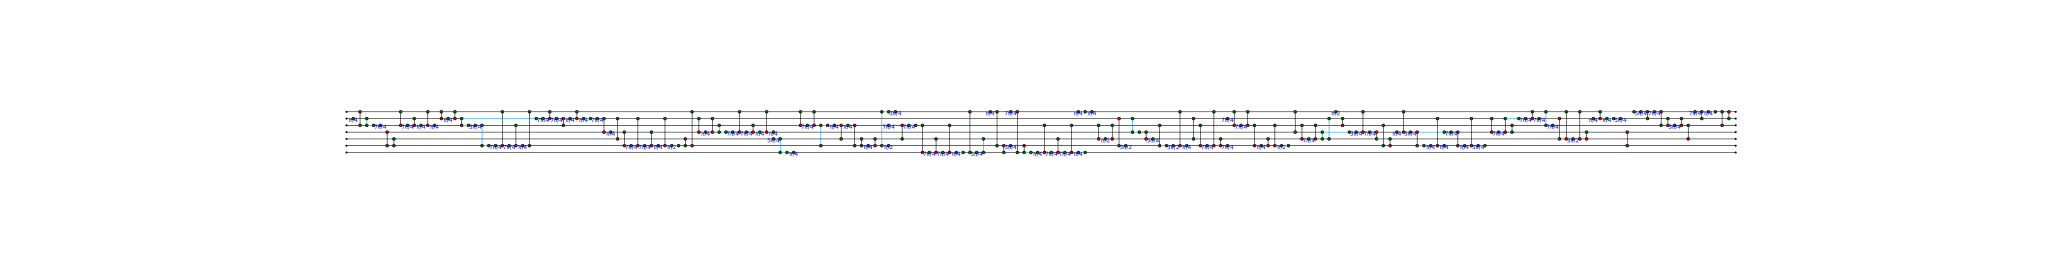

In [69]:
zx.draw(c2,figsize=(40,5))

In [63]:
c3 = zx.optimize.phase_block_optimize(c2)
print(c3.stats())

Circuit  on 7 qubits with 325 gates.
        73 is the T-count
        252 Cliffords among which 
        185 2-qubit gates and 26 Hadamard gates.


In [64]:
c4 = zx.optimize.basic_optimization(c3)
print(c4.stats())

Circuit  on 7 qubits with 297 gates.
        73 is the T-count
        224 Cliffords among which 
        167 2-qubit gates and 26 Hadamard gates.


In [66]:
cs = zx.extract.streaming_extract(s.simplifygraph.copy()).to_basic_gates()
cs = zx.optimize.basic_optimization(cs)
print(cs.stats())

Circuit  on 7 qubits with 361 gates.
        75 is the T-count
        286 Cliffords among which 
        226 2-qubit gates and 38 Hadamard gates.


In [46]:
zx.rules.match_pivot_parallel(s.simplifygraph)

[[62, 64, [4], []], [32, 37, [0], []]]

In [18]:
s = Simplifier(c.to_graph())
s.mastergraph.phase_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

spider_simp: 1. 1.  2 iterations


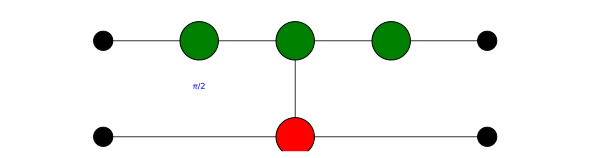

In [20]:
zx.draw(s.mastergraph)

In [8]:
zx.Circuit.load(circ_name).gates

[HAD(4),
 CCZ(c1=0,c2=1,t=4),
 HAD(4),
 HAD(3),
 CCZ(c1=2,c2=4,t=3),
 HAD(3),
 HAD(4),
 CCZ(c1=0,c2=1,t=4),
 HAD(4)]

[HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4), HAD(3), CCZ(c1=2,c2=4,t=3), HAD(3), HAD(4), CCZ(c1=0,c2=1,t=4), HAD(4)]


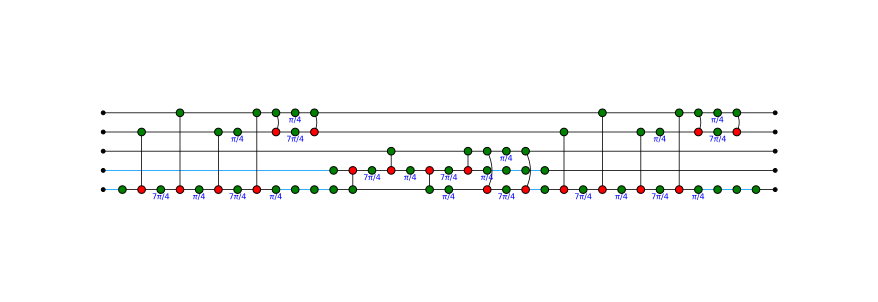

In [16]:
circ_name = r'../circuits/fast/tof_3_before'
c_orig = zx.Circuit.load(circ_name)
print(c_orig.gates)
zx.draw(c_orig,figsize=(12,4))

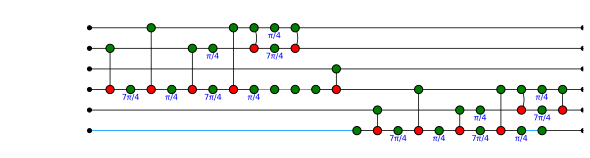

In [11]:
c = zx.Circuit(6)
c.add_gate("CCZ", 0, 1, 3)
c.add_gate("HAD", 3)
c.add_gate("CNOT", 2,3)
c.add_gate("TOF", 3, 4, 5)
zx.draw(c)

15


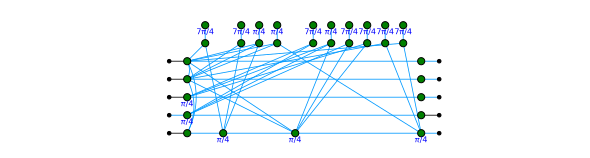

In [18]:
g = c_orig.to_graph()
zx.simplify.full_reduce(g)
g.normalise()
print(zx.tcount(g))
zx.draw(g)

In [6]:
c2 = zx.optimize.basic_optimization(c.to_basic_gates(),quiet=False)
print(c2.stats())

1.2.3.4.5.6.7.8.9.10.11.12.13.14.Circuit  on 12 qubits with 38373 gates.
        3517 is the T-count
        34856 Cliffords among which 
        28332 2-qubit gates and 3637 Hadamard gates.


In [4]:
def match_pivot_gadget(g, matchf=None, num=-1):
    if matchf != None: candidates = set([e for e in g.edges() if matchf(e)])
    else: candidates = g.edge_set()
    types = g.types()
    phases = g.phases()
    rs = g.rows()
    
    edge_list = []
    
    
    i = 0
    m = []
    
    while (num == -1 or i < num) and len(candidates) > 0:
        e = candidates.pop()
        v0, v1 = g.edge_st(e)

        if not (types[v0] == 1 and types[v1] == 1): continue

        v0a = phases[v0]
        v1a = phases[v1]
        
        if v0a not in (0,1):
            if v1a in (0,1):
                t = v0
                v0 = v1
                v1 = t
                t = v0a
                v0a = v1a
                v1a = t
            else: continue
        elif v1a in (0,1): continue
        # Now v0 has a Pauli phase and v1 has a non-Pauli phase
        
        v0n = list(g.neighbours(v0))
        v1n = list(g.neighbours(v1))
        if len(v0n) == 1 or len(v1n) == 1: continue # one of them is a phase gadget
        bad_match = False
        discard_edges = []
        for l in (v0n, v1n):
            for n in l:
                if types[n] != 1: 
                    bad_match = True
                    break
                ne = list(g.incident_edges(n))
                if len(ne) == 1: # v0 or v1 is a phase gadget
                    bad_match = True
                    break
                discard_edges.extend(ne)
            if bad_match: break
        if bad_match: continue
                
        if any(types[w]!=1 for w in v0n): continue
        if any(types[w]!=1 for w in v1n): continue
        # Both v0 and v1 are interior
        
        v = g.add_vertex(1,-2,rs[v0],v1a)
        g.set_phase(v1, 0)
        g.set_qubit(v0,-1)
        edge_list.append((v,v1) if v<v1 else (v1,v))
        
        m.append([v0,v1,[],[v]])
        i += 1
        for c in discard_edges: candidates.discard(c)
    g.add_edges(edge_list,1)
    return m

def pivot_gadget_simp(g, matchf=None, quiet=False):
    return zx.simplify.simp(g, 'pivot_gadget_simp', match_pivot_gadget, zx.rules.pivot, matchf=matchf, quiet=quiet)

pivot_gadget_simp: 17. 7. 8. 3. 1.  5 iterations
id_simp: 9.  1 iterations
spider_simp: 5.  1 iterations
lcomp_simp: 2. 2.  2 iterations


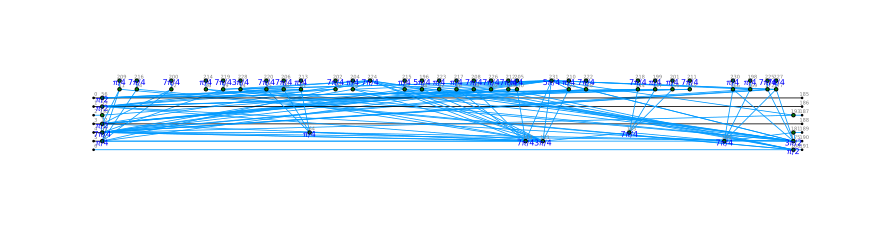

In [162]:
pivot_gadget_simp(g,quiet=False)
zx.simplify.interior_clifford_simp(g,quiet=False)
zx.draw(g,figsize=(12,3),labels=False)

In [163]:
zx.simplify.gadget_simp(g)

gadget_simp: 5.  1 iterations


1

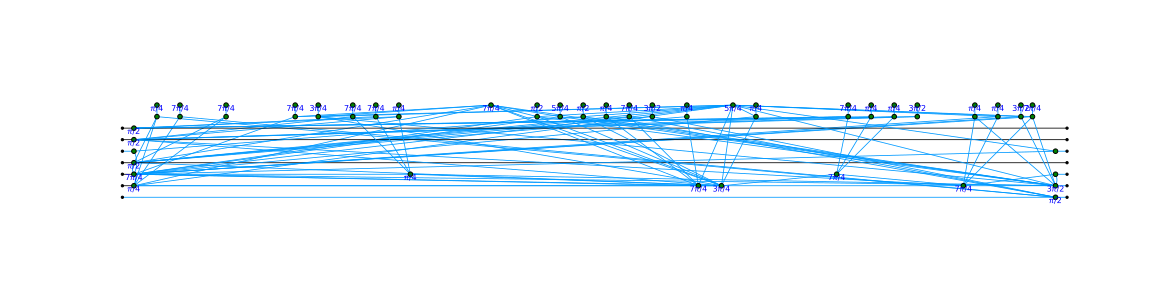

In [146]:
zx.draw(g,figsize=(16,4))

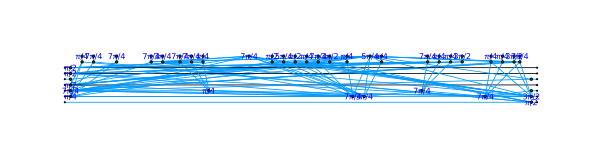

In [147]:
zx.simplify.pivot_simp(g)
zx.draw(g)

lcomp_simp: 5. 5.  2 iterations


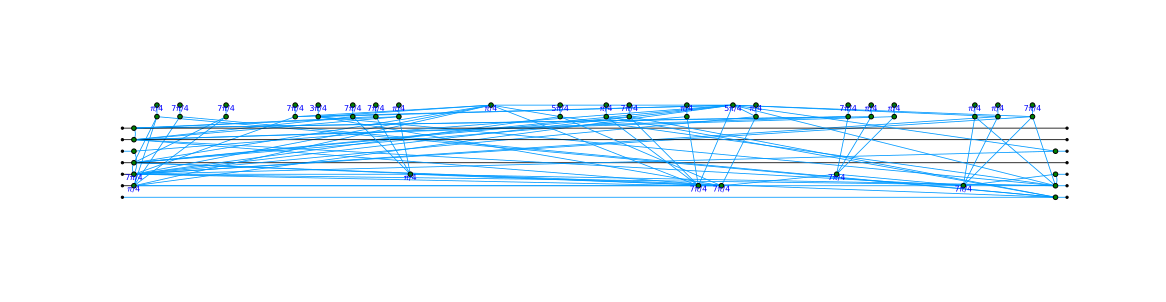

In [164]:
zx.simplify.lcomp_simp(g)
zx.draw(g,figsize=(16,4))

pivot_simp: 1.  1 iterations


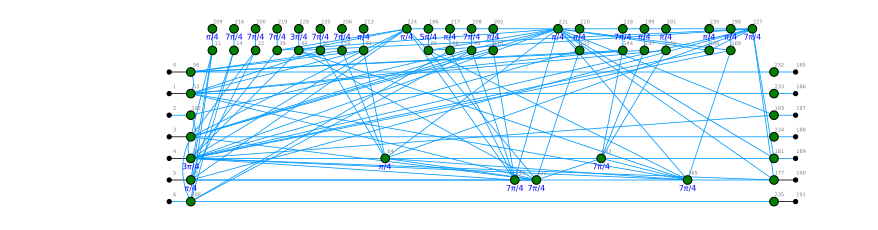

In [165]:
zx.simplify.clifford_simp(g)
g.normalise()
zx.draw(g,figsize=(12,3),labels=True)

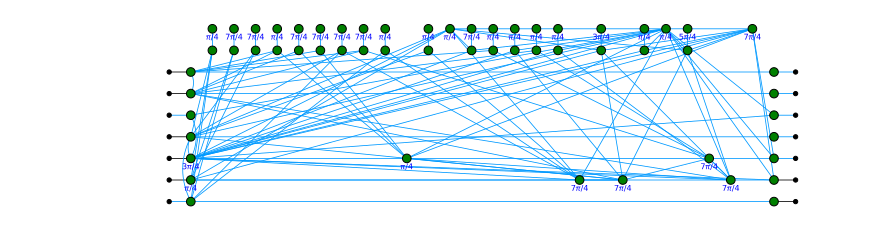

In [167]:
def sort_gadgets(g):
    rs = g.rows()
    ty = g.types()
    gadgets = {}
    for v in g.vertices():
        if len(list(g.neighbours(v))) == 1 and ty[v]==1:
            w = list(g.neighbours(v))[0]
            score = sum(rs[n] for n in g.neighbours(w))/len(list(g.neighbours(w)))
            gadgets[(w,v)] = score
    
    l = list(gadgets.items())
    l = sorted(l, key=lambda x: x[1])
    for i in range(len(l)):
        v,w = l[i][0]
        g.set_row(v, i+1.5)
        g.set_row(w, i+1.5)
    
sort_gadgets(g)
g.normalise()
zx.draw(g,figsize=(12,3))

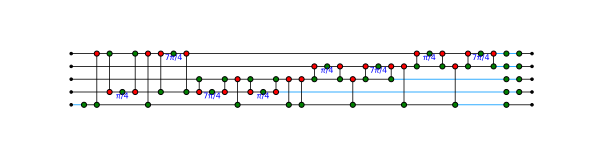

In [105]:
g2 = g.copy()
c = zx.extract.streaming_extract(g2)
zx.draw(c)

In [106]:
zx.compare_tensors(c_orig,c)

True

id_simp: 4.  1 iterations


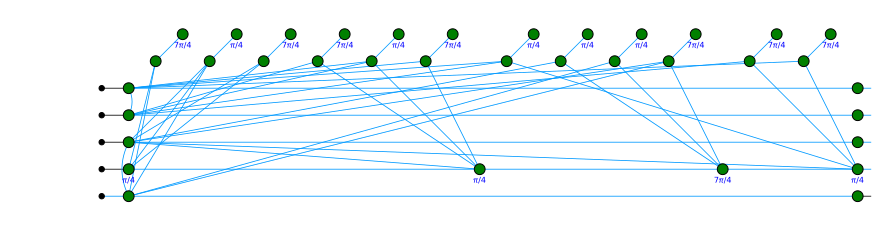

In [53]:
zx.simplify.gadget_simp(g)
zx.simplify.clifford_simp(g)
g.normalise()
zx.draw(g,figsize=(12,3))

In [41]:
zx.compare_tensors(c_orig,g)

ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [14]:
a = []
%timeit if not a: pass

25.7 ns ± 1.42 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [15]:
a = []
%timeit if len(a) == 0: pass

66.8 ns ± 0.588 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [23]:
from pyzx.circuit import ZPhase
from pyzx.linalg import Mat2
from pyzx.todd import todd_iter, MultiLinearPoly
#zx.todd.TOPT_LOCATION = os.path.expanduser("~/projects/pyzx/TOpt")
zx.todd.USE_REED_MULLER = False

def todd_on_graph(g):
    gadgets = {}
    t_nodes = []
    for v in g.vertices():
        if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
            if g.phase(v) != 0 and g.phase(v).denominator != 4: continue
            n = list(g.neighbours(v))[0]
            tgts = frozenset(set(g.neighbours(n)).difference({v}))
            gadgets[tgts] = (n,v)
        if g.phase(v) != 0 and g.phase(v).denominator == 4:
            t_nodes.append(v)
    
    if not gadgets:
        print("No phase gadgets found")
        return
    variables = set()
    for par in gadgets.keys():
        variables.update(par)
    
    for v in variables:
        if v in t_nodes:
            gadgets[frozenset({v})] = (v,v)
    
    targets = list(variables)
    n = len(targets)

    cols = []
    for par, (_,v) in gadgets.items():
        col = [0]*n
        for t in par:
            col[targets.index(t)] = 1
        phase = g.phase(v)
        for i in range(phase.numerator): cols.append(col)
        #cols.append(col)
    parmatrix = Mat2(cols).transpose()
    print(parmatrix.rows(), parmatrix.cols())
    #print(parmatrix)
    m2 = todd_iter(parmatrix)
    print(m2.rows(), m2.cols())
    
    newgadgets = []
    phases = dict()
    for col in m2.transpose().data:
        if sum(col) == 1:
            i = next(i for i,a in enumerate(col) if a)
            v = targets[i]
            if v in t_nodes:
                phases[v] = Fraction(1,4)
            else:
                phases[v] = g.phase(v) + Fraction(1,4)
        else:
            newgadgets.append(frozenset([targets[i] for i,a in enumerate(col) if a]))
    
    p = zx.todd.MultiLinearPoly()
    p.add_par_matrix(parmatrix,False)
    p.add_par_matrix(m2,True)
    correction = p.to_clifford()
    add_czs = {}
    for clif in correction:
        if isinstance(clif, ZPhase):
            v = targets[clif.target]
            if v in phases:
                phases[v] += clif.phase
            else:
                if v in t_nodes:
                    phases[v] = clif.phase
                else:
                    phases[v] = g.phase(v) + clif.phase
        elif clif.name == 'CZ':
            v1,v2 = targets[clif.control], targets[clif.target]
            add_czs[(v1,v2)] = (0,1)
    
    for v in targets:
        if v in phases:
            g.set_phase(v, phases[v])
        else:
            if v in t_nodes:
                g.set_phase(v, 0)
    g.add_edge_table(add_czs)
    
    rs = g.rows()
    positions = set()
    for gadget, (n,v) in gadgets.items():
        if len(gadget) == 1: continue # T-node
        if gadget in newgadgets:
            positions.add(rs[v])
            g.set_phase(v, Fraction(1,4))
            newgadgets.remove(gadget)
        else:
            g.remove_vertices((n,v))
    
    edges = []
    for par in newgadgets:
        pos = sum(rs[t] for t in par)/len(par) + 0.5
        while pos in positions: pos += 0.5
        n = g.add_vertex(1, -1, pos)
        v = g.add_vertex(1, -2, pos, phase=Fraction(1,4))
        edges.append((n,v))
        positions.add(pos)
        for t in par: edges.append((n,t))
    g.add_edges(edges, 2)
    

g2 = g.copy()
#display(zx.draw(g2,labels=True))
todd_on_graph(g2)
zx.full_reduce(g2)
g2.normalise()
print(zx.tcount(g2))
# todd_on_graph(g2)
# zx.full_reduce(g2)
# g2.normalise()
# print(zx.tcount(g2))
#zx.draw(g2)

7 57
7 13
13


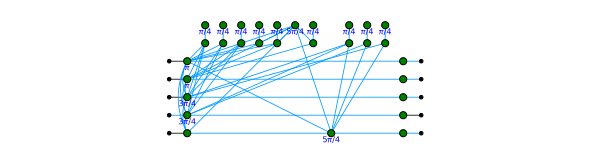

In [24]:
zx.draw(g2)

10
4
4


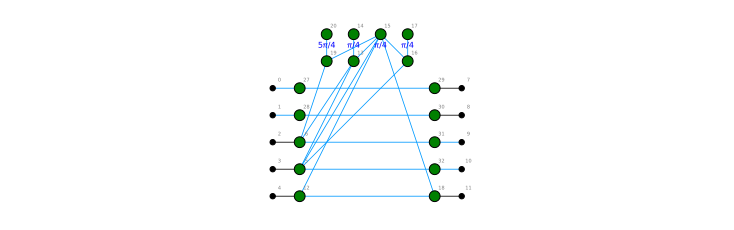

In [10]:
g3 = g2.copy()
try: c2 = zx.extract.streaming_extract(g3,allow_ancillae=True,quiet=True)
except: pass
print(zx.tcount(g3))
g3 = g3.adjoint()
try: c2 = zx.extract.streaming_extract(g3,allow_ancillae=True,quiet=True)
except: pass
zx.simplify.id_simp(g3, quiet=True)
g3.normalise()
print(zx.tcount(g3))
g3 = g3.adjoint()
try: c2 = zx.extract.streaming_extract(g3,allow_ancillae=True,quiet=True)
except: pass
zx.simplify.id_simp(g3, quiet=True)
g3.normalise()
print(zx.tcount(g3))
#zx.simplify.id_simp(g3, quiet=True)
zx.draw(g3,figsize=(10,3),labels=True)

18
[32, 23, 26]
found match!


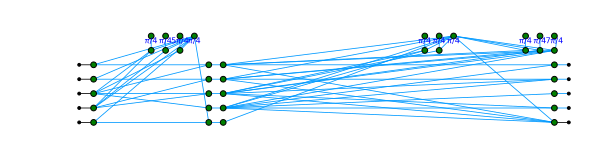

In [7]:
g = g3.copy()
q = len(g.inputs)
left = [v for v in g.vertices() if g.row(v) == 1]
gadgets = {}
gadget_reverse = {}
for v in g.vertices():
    if v not in g.inputs and v not in g.outputs and len(list(g.neighbours(v)))==1:
        if g.phase(v) != 0 and g.phase(v).denominator != 4: continue
        n = list(g.neighbours(v))[0]
        gadgets[n] = v
        gadget_reverse[v] = n
#extra = [36, 33, 38, 37]
left = left
right = set()
for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>1)
nodes = list(right.difference(gadgets))
gadgets_conn = list(right.intersection(gadgets))
#print(nodes)
#print(gadgets_conn)
right = list(right)
for w in nodes:
    right.remove(w)
    right.append(w)
#m = zx.extract.bi_adj(g, right, left)
for w in nodes:
    m = zx.extract.bi_adj(g, right, left+[w])
    if m.rank() > q:
        print(w)
        r = right.copy()
        r.remove(w)
        conn = []
        for gadget in gadgets_conn:
            if g.connected(gadget, w):
                conn.append(gadget)
                r.remove(gadget)
        print(conn)
        if len(conn) < 3: continue
        m = zx.extract.bi_adj(g, r, left+conn+[w])
        if m.rank() <= q+1:
            print("found match!")
            break
#m2 = zx.extract.bi_adj(g, r, left+conn+[w])
#print(m2.rank())
new_left = left+conn+[w]
for v in g.vertices():
    if v not in new_left:
        if v in gadget_reverse and gadget_reverse[v] in new_left: continue
        row = g.row(v)
        if row > 1:
            g.set_row(v, row+20)
new_right = zx.extract.cut_edges(g,new_left, r)
zx.draw(g)

In [24]:
#for e in g4.edges(): g4.set_edge_type(e, 1)
g4 = zx.quantomatic.edit_graph(g4)

Opening Quantomatic...
Done


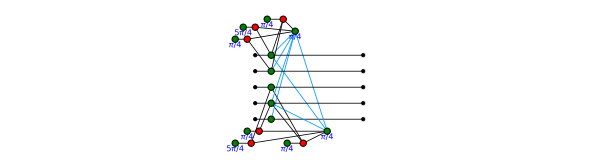

In [15]:
zx.draw(g4)

In [26]:
#print(zx.graph_to_json(g4))
print(zx.drawing.to_tikz(g4))


\begin{tikzpicture}
    \begin{pgfonlayer}{nodelayer}
        \node [style=Z dot] (0) at (1.00, -2.00) {};
        \node [style=X dot] (1) at (4.00, 1.00) {};
        \node [style=X dot] (2) at (3.00, 1.00) {};
        \node [style=Z dot] (3) at (6.00, -4.00) {};
        \node [style=Z phase dot] (4) at (2.00, 2.00) {$\frac{\pi}{4}$};
        \node [style=Z phase dot] (5) at (4.00, 2.00) {$\frac{\pi}{4}$};
        \node [style=X dot] (6) at (2.00, 1.00) {};
        \node [style=Z dot] (7) at (1.00, 0.00) {};
        \node [style=Z phase dot] (8) at (4.25, -2.50) {$\frac{5\pi}{4}$};
        \node [style=Z dot] (9) at (1.00, -3.00) {};
        \node [style=Z dot] (10) at (1.00, -1.00) {};
        \node [style=Z dot] (11) at (1.00, -4.00) {};
        \node [style=Z phase dot] (12) at (3.00, 2.00) {$\frac{\pi}{4}$};
        \node [style=none] (13) at (7.00, -4.00) {};
        \node [style=none] (14) at (7.00, -2.00) {};
        \node [style=none] (15) at (0.00, -4.00) {};
        \node [s

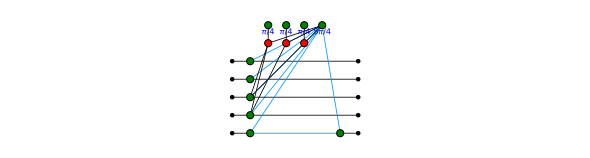

In [23]:
g4 = g3.copy()
zx.simplify.id_simp(g4,quiet=True)
zx.to_rg(g4,select=lambda v: all(g4.edge_type(e)==2 for e in g4.incident_edges(v)) and g4.phase(v)==0)
zx.draw(g4)

In [183]:
zx.is_unitary(g4)

True

In [47]:
g6 = zx.quantomatic.edit_graph(g4)

Opening Quantomatic...
Done


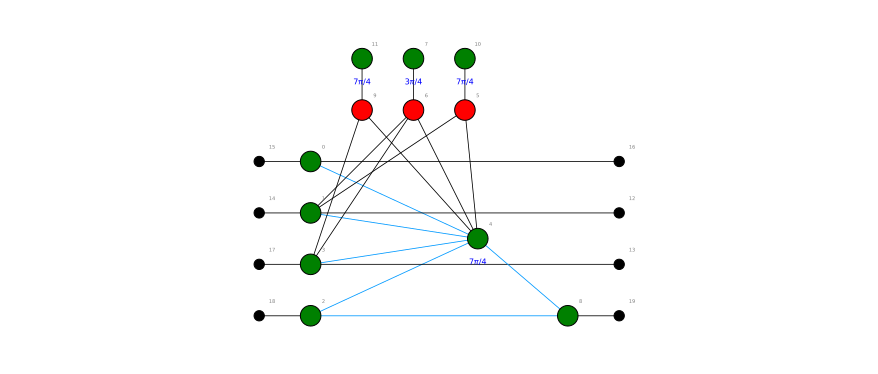

In [153]:
zx.draw(g6,figsize=(12,5), labels=True)

True


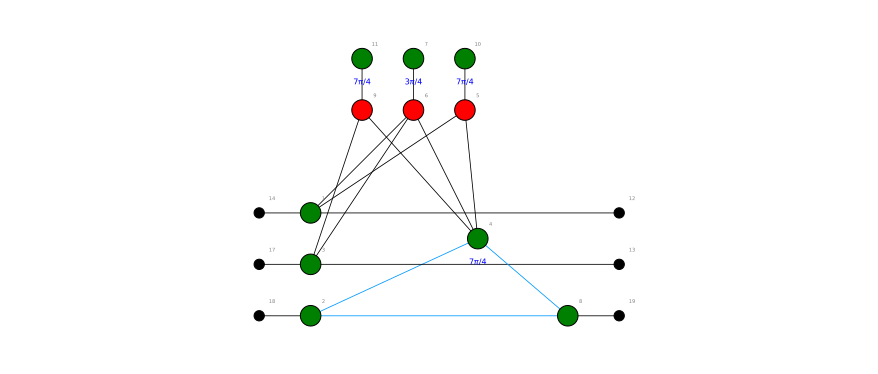

In [172]:
g7 = g6.copy()
# g7.remove_vertices([18,2,8,19])
# g7.inputs.remove(18)
# g7.outputs.remove(19)
g7.remove_vertices([15,0,16])
g7.inputs.remove(15)
g7.outputs.remove(16)

# targets = [11,7,10,4]
# options = [Fraction(1,4),Fraction(3,4),Fraction(5,4),Fraction(7,4)]
# for a in options:
#     g7.set_phase(targets[0],a)
#     for b in options:
#         g7.set_phase(targets[1],b)
#         for c in options:
#             g7.set_phase(targets[2],c)
#             for d in options:
#                 g7.set_phase(targets[3],d)
#                 print(a,b,c,d, (a+b+c+d).denominator, zx.is_unitary(g7))
#for v in targets: g7.set_phase(v,Fraction(1,4))
#g7.set_phase(7,Fraction(7,4))
#g7.set_phase(7,Fraction(3,4))
g7.remove_edges([(1,4),(3,4)])
#g7.set_edge_type((2,8),1)
#g7.normalise()
print(zx.is_unitary(g7))
zx.draw(g7, figsize=(12,5),labels=True)

In [173]:
g8 = g7.copy()
g8.normalise()
#g8.compose(g8.adjoint())
#zx.full_reduce(g8)
#zx.draw(g8)
#g8.set_qubit(2, 0.5)
t = g8.to_tensor()
t/t.flatten()[0]

array([[[[[[ 1.+0.j, -0.+0.j],
           [-0.+0.j, -1.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[-0.-0.j,  0.+1.j],
           [ 0.+1.j,  0.+0.j]]]],



        [[[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]]]],




       [[[[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]]],



        [[[[-0.-0.j,  0.+1.j],
           [ 0.+1.j,  0.+0.j]],

          [[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]]],


         [[[ 0.+0.j,  0.+0.j],
           [ 0.+0.j,  0.+0.j]],

          [[-0.-0.

In [175]:
a = zx.Circuit(3)
a.add_gate("NOT",0)
a.add_gate("NOT",1)
a.add_gate("Z",0)
a.add_gate("Z",1)
a.add_gate("S",2)
a.add_gate("HAD",2)
a.add_gate("NOT",2)
a.add_gate("Z",2)
a.add_gate("CCZ",0,1,2)
a.add_gate("NOT",2)
a.add_gate("HAD",2)
a.add_gate("S",2)
a.add_gate("NOT",1)
a.add_gate("NOT",0)
t2 = a.to_tensor()
zx.compare_tensors(t,t2)

True

In [141]:
a = zx.Circuit(3)
a.add_gate("CNOT",0, 2)
a.add_gate("InitAncilla",'a')
a.add_gate("HAD", 'a')
a.add_gate("CNOT", 2, 'a')
a.add_gate("CNOT", 1, 'a')
a.add_gate("T", 0, adjoint=True)
a.add_gate("T", 1, adjoint=True)
a.add_gate("T", 2, adjoint=False)
a.add_gate("T", 'a', adjoint=True)
a.add_gate("CNOT", 1, 'a')
a.add_gate("CNOT", 2, 'a')
a.add_gate("CNOT",0, 2)
a.add_gate("CNOT",1, 0)
a.add_gate("CNOT",2, 1)
a.add_gate("T", 0, adjoint=False)
a.add_gate("T", 1, adjoint=False)
a.add_gate("T", 2, adjoint=True)
a.add_gate("CNOT",2, 1)
a.add_gate("CNOT",1, 0)
a.add_gate("HAD", 'a')
a.add_gate("PostSelect", 'a')

b = zx.Circuit(3)
b.add_gate("CCZ",0,1,2)
zx.compare_tensors(a,b)
#t2/t2.flatten()[0]
# b = a.to_graph()
# b.inputs, b.outputs

True

In [142]:
a = zx.generate.identity(1)
a = zx.quantomatic.edit_graph(a)

Opening Quantomatic...
Done


In [149]:
a.auto_detect_inputs()
a.normalise()
a.to_tensor()

array([[0.25-0.25j, 0.25-0.25j],
       [0.25-0.25j, 0.25-0.25j]])

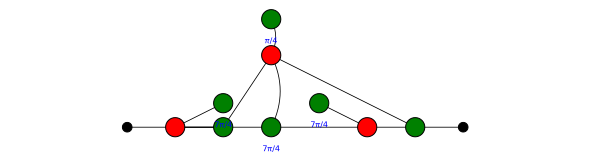

In [152]:
zx.draw(a)

In [150]:
b = zx.generate.identity(1)
b = zx.quantomatic.edit_graph(b)
b.auto_detect_inputs()
b.normalise()
b.to_tensor()

Opening Quantomatic...
Done


array([[1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j]])

In [151]:
zx.compare_tensors(a,b)

True

In [110]:
zx.generate.identity(2).to_tensor()

array([[[[1., 0.],
         [0., 1.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[1., 0.],
         [0., 1.]]]])

In [87]:
s = zx.io.graph_to_json(g7)
fname = r'..\circuits\horrible_unitary_small.qgraph'
with open(fname, 'w') as f:
    f.write(s)


In [22]:
import subprocess
import os
s = subprocess.check_output(["../TOpt", "gsm","../testmatrix.gsm"]).decode()

In [4]:
g2 = g.copy()
zx.simplify.to_rg(g2)
zx.quantomatic.edit_graph(g2)

Opening Quantomatic...
Done


Graph(13 vertices, 21 edges)

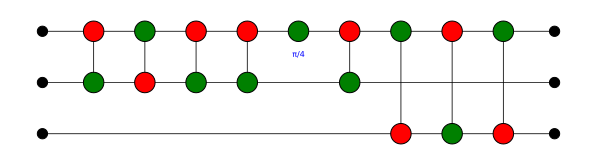

In [220]:
c = zx.Circuit(3)
qubits = c.qubits
c.add_gate("SWAP",1,0)
c.add_gate("ParityPhase", Fraction(1,4),1,0)
c.add_gate("SWAP",0,2)
zx.draw(c)

1.

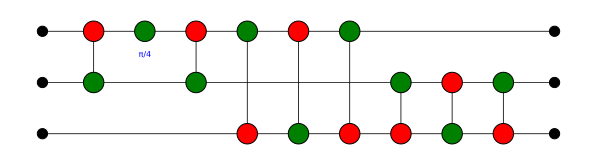

In [228]:
o = zx.optimize.Optimizer(c.to_basic_gates())
circuit, correction = o.parse_circuit(separate_correction=True, quiet=False)
zx.draw(zx.optimize.phase_block_optimize(c.to_basic_gates()))

In [225]:
correction

[SWAP(0,2), SWAP(1,2)]

In [11]:
from pyzx.circuit import SWAP
qubits = 3
permutation = {i:i for i in range(qubits)}
correction = [SWAP(0,1),SWAP(0,2)]
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))

permutation = {v:k for k,v in permutation.items()}
zx.extract.permutation_as_swaps(permutation)
#permutation

[(0, 2), (1, 2)]

In [227]:
permutation = {i:i for i in range(qubits)}
nots = []
for g in correction:
    if g.name == 'SWAP':
        a = permutation[g.control]
        b = permutation[g.target]
        permutation[g.control] = b
        permutation[g.target] = a
    elif g.name == 'NOT':
        nots.append(g)
    else:
        raise TypeError("Illegal correction {}".format(str(g)))
permutation = {v:k for k,v in permutation.items()}
permutation

{2: 0, 0: 1, 1: 2}

In [198]:
phase_poly, parity_polys = zx.todd.phase_gates_to_poly(c.to_basic_gates().gates, c.qubits)
phase_poly, parity_polys

(x0@x1, [x2, x0, x1])

In [199]:
from pyzx.phasepoly import parity_network
m = phase_poly.to_par_matrix()
newgates = []
parities = []
for col in m.transpose().data:
    #if sum(col) == 1:
    #    newgates.append(T(next(i for i in range(qubits) if col[i])))
    #else:
    parities.append(col)

cnots = parity_network(c.qubits, parities)
parities

[[1, 1, 0]]

In [164]:
cnots

[CNOT(1,0)]

In [200]:
m = zx.Mat2.id(c.qubits)
for cnot in cnots:
    m.row_add(cnot.control, cnot.target)
m

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [166]:
m.to_cnots()

[CNOT(0,1)]

In [201]:
data = []
for p in parity_polys:
    l = [int(i in p.par) for i in range(c.qubits)]
    data.append(l)

m2 = zx.Mat2(data)
m2

[ 0  0  1 ]
[ 1  0  0 ]
[ 0  1  0 ]

In [202]:
target_matrix = zx.Mat2(data) * m.inverse()
target_matrix

[ 0  0  1 ]
[ 1  1  0 ]
[ 0  1  0 ]

In [207]:
perm = zx.linalg.column_optimal_swap(target_matrix.transpose())
swaps = zx.extract.permutation_as_swaps(perm)
m2 = target_matrix.copy()
for a,b in swaps:
    m2.row_swap(a,b)

inv = {v:k for k,v in perm.items()}
m2

[ 1  1  0 ]
[ 0  1  0 ]
[ 0  0  1 ]

In [208]:
trueswaps = zx.extract.permutation_as_swaps(inv)
trueswaps

[(0, 2), (1, 2)]

In [194]:
perm, swaps

({3: 0, 0: 1, 1: 2, 2: 3}, [(0, 3), (1, 3), (2, 3)])

In [205]:
gates = m2.to_cnots(optimize=True)
gates

[CNOT(0,1)]

In [56]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([1,3,4,5])
s3 = generate_parities([1,2,4,5])
#s5 = generate_parities([1,2,3,5])
s1.symmetric_difference(s2).symmetric_difference(s3)#.symmetric_difference(s4))#.symmetric_difference(s5)

{frozenset({1, 2, 3, 4}),
 frozenset({3, 5}),
 frozenset({1, 3, 5}),
 frozenset({2, 3}),
 frozenset({4}),
 frozenset({2, 3, 4}),
 frozenset({2, 5}),
 frozenset({1}),
 frozenset({1, 2, 4, 5}),
 frozenset({1, 2, 3}),
 frozenset({3, 4, 5}),
 frozenset({1, 4}),
 frozenset({1, 3, 4, 5}),
 frozenset({1, 2, 5}),
 frozenset({2, 4, 5})}

In [ ]:
[ 1  1  0  0  1  0  1  0 ]
[ 1  1  1  0  0  1  0  0 ]
[ 0  1  0  1  1  1  0  0 ]
[ 1  0  0  0  1  1  0  1 ]
[ 1  0  1  1  1  0  0  0 ]

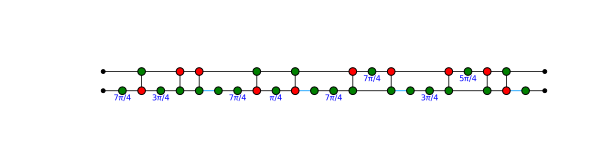

In [5]:
g = zx.generate.circuit_identity_commuting_controls(Fraction(1,4),Fraction(1,4))
zx.simplify.full_reduce(g)
c = zx.extract.streaming_extract(g).to_basic_gates()
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
c3, blocks = circuit_phase_polynomial_blocks(c2,optimize=True)
zx.draw(c3)

[]


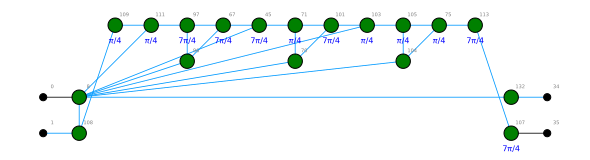

In [39]:
#c = generate_identity(Fraction(5,4),Fraction(7,4))
g = c.to_graph()
zx.simplify.full_reduce(g)
zx.simplify.full_reduce(g)
# zx.simplify.gadgetize(g)
# edges = [(49,55),(55,49),(59,65),(65,59)]
# zx.simplify.pivot_simp(g,matchf=lambda e: e in edges)
# zx.simplify.id_simp(g)
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
#print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
#zx.gadget_simp(g)
# zx.simplify.id_simp(g)
#zx.full_reduce(g)
g.normalise()
zx.draw(g,labels=True)

In [35]:
zx.compare_tensors(g.to_tensor(), zx.generate.identity(2).to_tensor())

True

In [31]:
zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


Graph(18 vertices, 23 edges)

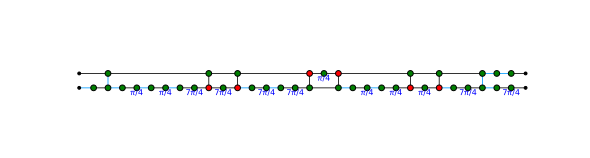

In [36]:
g2 = g.copy()
c2 = zx.extract.streaming_extract(g2)
zx.draw(c2.to_graph())

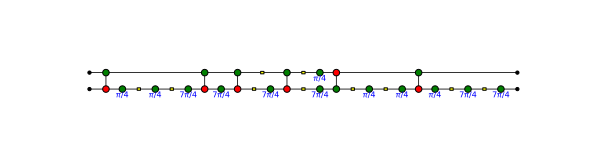

In [37]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
g = c4.to_graph()
zx.simplify.id_simp(g,quiet=True)
zx.draw(g,h_edge_draw='box')

In [42]:
zx.compare_tensors(c4,zx.identity(2))

True

In [156]:
g = zx.generate.identity(1,3)
g = zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


In [21]:
a = zx.Circuit(2)
a.add_gate("CZ",0,1)
a.add_gate("CNOT",0,1)
b = zx.Circuit(2)
b.add_gate("S",0)
b.add_gate("S",1)
b.add_gate("CNOT",0,1)
b.add_gate("S",1, adjoint=True)
zx.compare_tensors(a,b)

True

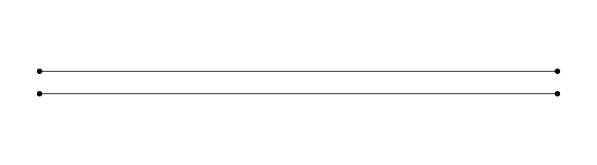

In [49]:
alpha = Fraction(3,5)
beta= Fraction(5,7)

c = zx.Circuit(2)
c.add_gate("XPhase", 1, alpha)
c.add_gate("ZPhase", 1, beta)
c.add_gate("XPhase", 1, alpha)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_gate("CNOT",0,1)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("NOT", 1)
c.add_gate("ZPhase", 1, -beta)
c.add_gate("XPhase", 1, -alpha)
c.add_gate("CNOT",0,1)
c.add_gate("NOT", 0)
c.add_gate("NOT", 1)
c.add_circuit(c)
g = c.to_graph()
zx.full_reduce(g)
zx.draw(g)